In [11]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from transformers import LlamaForCausalLM, LlamaTokenizerFast
import torch

model_id = "gpt2"
dataset="multisimo"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = f"../data/processed/{dataset}/conversations.csv"
ppl_path = f"../information_exchange_labelling/dataset_perplexity_results/{dataset}_p1_{model_id}/"
output_path = f"/u/sebono/conversational_dominance/data/processed/{dataset}_{model_id}/"
perplexity_func = "p1"
time_field = {"START": "start", "STOP": "stop"}
bin_width=1
index_path=f"/u/sebono/conversational_dominance/data/processed/{dataset}/group_3.csv"

In [12]:
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
start_of_sentence =" "

/u/sebono/miniconda3/envs/.bewellenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
import torch
from tqdm import tqdm
from torch.nn.functional import pad

def p1(dialog, start_of_sentence):
    
    max_length = model.config.n_positions
    stride = 1
    
    pad_token_id = 0
    encodings = tokenizer(f"{start_of_sentence}".join(dialog), return_tensors="pt")
    seq_len = encodings.input_ids.size(1)
    padding_len = max_length -1 
    padded_input_ids = pad(torch.tensor([], dtype=torch.long), (0, padding_len), value=pad_token_id).unsqueeze(dim=0)
    encodings.input_ids = torch.cat([padded_input_ids, encodings.input_ids], dim=1)
    seq_len = encodings.input_ids.size(1)
    nlls = []
    prev_end_loc = padding_len
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from max_length on the last loop 
        begin_loc = max(padding_len, begin_loc)
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood.item())

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    return nlls

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# Assuming 'matches', 'dialog', 'offset', and 'perpl' are defined earlier in your code
def perplexity_to_info(dialog, tokens, perpl, answers, pattern = '<(SPK[1-9]|MOD)>'):

    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    #encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    ppl_to_info = []
    prev_idx_pp = 0
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(r'\[([^\]]+)\]: ', '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return ppl_to_info

def filter_out_common_words(words, perpl):
    # Remove stop words and corresponding perplexity values
    filtered_words = [word for word in words if word.lower().strip() not in STOP_WORDS]
    filtered_word_indices = [i for i, word in enumerate(words) if word.lower().strip() not in STOP_WORDS]
    assert len(list(np.asarray(perpl)[filtered_word_indices])) == len(filtered_words)
    return list(np.asarray(perpl)[filtered_word_indices]), filtered_word_indices

def perplexity_to_info_filtering_out_common_words(dialog, tokens, perpl, answers, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    
    ppl_to_info = []
    prev_idx_pp = 0
    dialog_filtered = []
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        dialog_filtered.append(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
        
    return dialog_filtered, ppl_to_info

def compute_per_user_mean_perplexity_filtering_out_common_words(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):

    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    prev_idx_pp = 0
    user_to_ppl = {}
    decoded_utterances = []
    for idx, match in enumerate(matches):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        decoded_utterances.append([tokenizer.decode([token], skip_special_tokens=True) for token in tokens[filtered_word_indices]])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return user_to_ppl, decoded_utterances

def compute_per_user_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    #matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    user_to_ppl = {}
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return  user_to_ppl
    
def compute_graph_perplexity(tokens, p1,p2, matches, pattern = '<(SPK[1-9]|MOD)>', answers=None):
    
    dialog = [tokenizer.decode(token, skip_special_tokens=True) for token in tokens]
    unique_matches = np.unique(matches)
    
    rows = int(np.ceil(np.sqrt(len(dialog))))
    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(rows, rows, figsize=(30, 30))
    num_plots = len(dialog)
    # Set smaller font size
    plt.rcParams.update({'font.size': 8})
    
    assert num_plots == len(matches)
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(p1)
    
    prev_idx_pp = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            idx_pp = tokens_ids_per_sentence[idx]
            patt = matches[idx]
            tokens = encodings[prev_idx_pp:idx_pp]
            decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
            p1_per_sent = p1[prev_idx_pp:idx_pp]
            p2_per_sent = p2[prev_idx_pp:idx_pp]
            ax.plot(np.asarray(p1_per_sent), label=f'{patt} p1')
            #ax.plot(np.asarray(p2_per_sent), label=f'{patt} p2', color='r')
            #mean_value=np.nanmean(np.asarray(perpl_per_sent))
            ax.axhline(p1_per_sent[0], color='g', label=f'{patt} p3')  # Fixed the color argument
            ax.set_xticks(np.arange(len(decoded)))
            ax.set_xticklabels(decoded, rotation=90)
            if answers is not None:
                ax.set_title(f'{answers[idx]}')
            ax.legend()
            prev_idx_pp=idx_pp

    # Hide any remaining empty subplots
    for ax in axes.flatten()[num_plots:]:
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.5, top=0.95)  
    plt.suptitle("Per-Word Perplexity across the Dataset", fontsize=30)
    plt.legend()
    plt.show()

[nltk_data] Downloading package punkt to /u/sebono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /u/sebono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Multisimo

In [5]:
import numpy as np
import re
import pandas as pd

In [6]:
multisimo_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/multisimo/conversations.csv")
multisimo_df

,file_name,file_content
0,S02,<MOD> Ok so thanks for coming today. we're goi...
1,S03,<MOD> Ok hello we are going to play a quiz. <...
2,S04,"<MOD> ok Hello, thank you for coming today, we..."
3,S05,"<MOD> Ok hi welcome, thank you for coming toda..."
4,S07,"<MOD> <MOD> Ok. So welcome, thank you very muc..."
5,S08,<MOD> So good evening <SPK2> Good evening. <MO...
6,S09,<MOD> Ok <SPK2> Yeah so <MOD> So I would like ...
7,S10,<MOD> Ok. So I would like us to play a quiz. O...
8,S11,"<SPK1> <MOD> Right. So, I would like us to pla..."
9,S13,"<SPK1> yeah <MOD> Well hello, thanks very much..."


In [53]:
# load perplexity
import os
import pickle

p1_multisimo_path = "../information_exchange_labelling/dataset_perplexity_results/multisimo_p1"
assert os.path.exists(p1_multisimo_path)

perplexity_scores_list = []
perplexity_scores_list_p3 = []
for root, dirs, files in os.walk(p1_multisimo_path):
    for file in files:
        if file.endswith('.pkl'):
            file_name = file.replace("dominance_scores_","").replace(".pkl","")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                loaded = pickle.load(f)
                perplexity_scores_list.append(loaded)

perplexity_scores_p1 = {k:v for element in perplexity_scores_list for k,v in element.items()}

In [60]:
def create_extended_list(lst, arr):
    result = []
    prev_count = 0
    for i, count in enumerate(arr):
        result.extend([lst[i]] * (count - prev_count))
        prev_count = count
    return result

def compute_p3(multisimo_df, perplexity_scores_p1, pattern = '<(SPK[1-9]|MOD)>'):
    perplexity_scores_p3 = {}
    for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
        content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
        content = [re.sub(pattern,">", d) for d in content]
        assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
        assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
        tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
        value = np.asarray([0] + list(np.asarray(perplexity_scores_p1[name])[tokens_ids_per_sentence[:-1]]))
        tokens_value = np.asarray([0] + list(np.asarray(torch.cat(tokens))[tokens_ids_per_sentence[:-1]]))
        perplexity_scores_p3[name] = create_extended_list(value, tokens_ids_per_sentence)
        assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)

    return perplexity_scores_p3

In [9]:
perplexity_scores_p3 = compute_p3(multisimo_df, perplexity_scores_p1)

Token indices sequence length is longer than the specified maximum sequence length for this model (3307 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
perplexity_scores_p3.keys()

dict_keys(['S02', 'S03', 'S04', 'S05', 'S07', 'S08', 'S09', 'S10', 'S11', 'S13', 'S14', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23'])

In [ ]:
perplexity_scores_p1

In [ ]:
dominance = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    dominance[name] = {}
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
    compute_graph_perplexity(tokens,perplexity_scores_p1[name],perplexity_scores_p3[name],matches, pattern=pattern) 

In [71]:
dominance_p1 = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    print(name)
    dominance_p1[name] = {}
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p1[name], matches, pattern=pattern)
    for patt in result.keys():
        if patt in np.unique(matches):
            print(f"{patt}: {np.mean(result[patt])}")
            dominance_p1[name][patt] = np.mean(result[patt])

S02


KeyError: 'S02'

In [ ]:
dominance_p3 = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    print(name)
    dominance_p3[name] = {}
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p3[name], matches, pattern=pattern)
    for patt in result.keys():
        if patt in np.unique(matches):
            print(f"{patt}: {np.mean(result[patt])}")
            dominance_p3[name][patt] = np.mean(result[patt])

In [ ]:
path = "/u/sebono/conversational_dominance/data/processed/multisimo/"
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)
with open(f'{path}/dominance_p2.pkl', 'wb') as f:
    pickle.dump(dominance_p2, f)
with open(f'{path}/dominance_p3.pkl', 'wb') as f:
    pickle.dump(dominance_p3, f)

In [ ]:
path = "/u/sebono/conversational_dominance/data/processed/multisimo/"
with open(f'{path}/dominance_p1.pkl', 'rb') as f:
    dominance_p1 = pickle.load(f)
with open(f'{path}/dominance_p2.pkl', 'rb') as f:
    dominance_p2 = pickle.load(f)
with open(f'{path}/dominance_p3.pkl', 'rb') as f:
    dominance_p3 = pickle.load(f)

In [ ]:
pd.DataFrame(dominance_p1), pd.DataFrame(dominance_p2), pd.DataFrame(dominance_p3)

In [ ]:
multisimo_df_dominance = pd.read_csv("../data/processed/multisimo/transcript_dominance.csv")

In [ ]:
df_ppxl_p1 = pd.DataFrame(dominance_p1).T
df_ppxl_p1.index.name = "file_name"
final_results_ppxl_p1_multisimo = pd.merge(multisimo_df_dominance,df_ppxl_p1, on="file_name")

results = pd.DataFrame({"one":final_results_ppxl_p1_multisimo["speaker_1_dom_score"]>final_results_ppxl_p1_multisimo["speaker_2_dom_score"],"two": final_results_ppxl_p1_multisimo["SPK1"]>final_results_ppxl_p1_multisimo["SPK2"]})
sum(results["one"]==results["two"])/len(results["one"])

In [ ]:
df_ppxl_p2 = pd.DataFrame(dominance_p2).T
df_ppxl_p2.index.name = "file_name"
final_results_ppxl_p2_multisimo = pd.merge(multisimo_df_dominance,df_ppxl_p2, on="file_name")

results = pd.DataFrame({"one":final_results_ppxl_p2_multisimo["speaker_1_dom_score"]>final_results_ppxl_p2_multisimo["speaker_2_dom_score"],"two": final_results_ppxl_p2_multisimo["SPK1"]>final_results_ppxl_p2_multisimo["SPK2"]})
sum(results["one"]==results["two"])/len(results["one"])

In [ ]:
df_ppxl_p3 = pd.DataFrame(dominance_p3).T
df_ppxl_p3.index.name = "file_name"
final_results_ppxl_p3_multisimo = pd.merge(multisimo_df_dominance,df_ppxl_p3, on="file_name")

results = pd.DataFrame({"one":final_results_ppxl_p3_multisimo["speaker_1_dom_score"]>final_results_ppxl_p3_multisimo["speaker_2_dom_score"],"two": final_results_ppxl_p3_multisimo["SPK1"]>final_results_ppxl_p3_multisimo["SPK2"]})
sum(results["one"]==results["two"])/len(results["one"])

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [ ]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [ ]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [ ]:
final_df = pd.concat((pd.DataFrame(dominance_p1).add_suffix("_P1",axis=0),pd.DataFrame(dominance_p2).add_suffix("_P2",axis=0),pd.DataFrame(dominance_p3).add_suffix("_P3",axis=0))).T
final_df

In [ ]:
# p1 - p2
col_1 = ["MOD_P1","SPK1_P1","SPK2_P1"] 
col_2 = ["MOD_P2","SPK1_P2","SPK2_P2"]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

In [ ]:
# p1 - p3
col_1 = ["MOD_P1","SPK1_P1","SPK2_P1"] 
col_2 = ["MOD_P3","SPK1_P3","SPK2_P3"]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

In [ ]:
# p2 - p3
col_1 = ["MOD_P1","SPK1_P1","SPK2_P1"] 
col_2 = ["MOD_P3","SPK1_P3","SPK2_P3"]
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df)

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [ ]:
y_s = final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score"]]
X = final_results_ppxl_multisimo[["SPK1","SPK2"]]
col_1 = list(X.keys())
col_2 = list(y_s.keys())
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_results_ppxl_multisimo[["speaker_1_dom_score","speaker_2_dom_score","SPK1","SPK2"]])

In [ ]:
dialog_filtered_tokens, info = perplexity_to_info_filtering_out_common_words(d,ppl_d,answers)
perpl = []
answers = []
for el in info:
    answers.append(el['label'])
    perpl += list(el['perpl'])
compute_graph_perplexity(dialog_filtered_tokens,perpl,answers=answers)

In [ ]:
###TO BE FIXED: there are some spaces that mess up the tokenization and detokenization

for el, dataset in zip(info, multisimo_df['file_content']):
    print(f"plotting {el}")
    dataset = re.sub(r'\[', r'\n[', content).split("\n")[1:]
    perplexity = []
    for sentence in info[el]:
        perplexity += list(sentence["perpl"]) 
    compute_graph_perplexity(dataset,perplexity)

In [ ]:
for i, (info_u, dataset) in enumerate(zip(info.keys(), considered_datasets_filtered)):
    for u, d in zip(info[info_u][1:], dataset.split("\n")[1:]):
        """filtering out assertive sentences like "'[Teacher]: "Very good. Continue."',
             '[Teacher]: "Please, go ahead."',
             '[Teacher]: "That\'s correct."',
             '[Teacher]: "Very good. Continue."',"""
        per_label_ppl[u['label']] += list(u['perpl'])
        per_label_dataset[u['label']].append(d)

### Tobedone when we have labels for MULTISIMO

In [ ]:
considered_datasets =multisimo_df["file_content"]

per_label_dataset={"Information seeking":[], "Information giving":[],"same":[]}
per_label_ppl={"Information seeking":[], "Information giving":[],"same":[]}

for dataset in considered_datasets:
    dataset = dataset.split("\n")
    labels = ["same" for _ in range(len(dataset))]
    encodings = tokenizer(dataset, return_tensors="pt")
    tokens_ids_per_sentence = np.cumsum([tokenizer(p, return_tensors="pt").input_ids.size(1) for p in dialog])
    prev_idx_pp = 0
    for idx, (d, l) in enumerate(zip(dataset,labels)):
        idx_pp = tokens_ids_per_sentence[idx]
        offset_ppl = len(tokenizer(d, return_tensors="pt"))
        per_label_dataset[l].append(d)
        per_label_ppl[l] += perplexity_scores[idx][prev_idx_pp:idx_pp]
        prev_idx_pp=idx_pp

### Other Dominance Indicators

In [ ]:
def count_user_utterances(content, pattern='<(SPK[1-9]|MOD)>'):
    content = " ".join(content)
    count_utterance_p_user = {}
    count_turns_p_user = {}
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    for el in np.unique(np.array(matches)):
        all_utt_p_user = [c for c in content if el in c]
        all_utt_p_user_n = sum([len(u.split(".")) for u in all_utt_p_user])
        count_utterance_p_user[el]=len(all_utt_p_user)
        count_turns_p_user[el] = np.sum(np.asarray(matches) == el)
    return count_utterance_p_user, count_turns_p_user

In [ ]:
multisimo_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/multisimo/conversations.csv")

count_utterance_p_user_l = {}
count_turns_p_user_l = {}
for content, name in zip(multisimo_df["file_content"], multisimo_df["file_name"]):
    count_utterance_p_user_l[name] = {}
    count_turns_p_user_l[name] = {}
    print(name)
    dominance[name] = {}
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    count_utterance_p_user, count_turns_p_user = count_user_utterances(content, pattern=pattern)
    for cu, ct in zip(count_utterance_p_user, count_turns_p_user):
        count_utterance_p_user_l[name][cu] = count_utterance_p_user[cu]
        count_turns_p_user_l[name][ct] = count_turns_p_user[ct]
        print(f"{cu}:", count_utterance_p_user[cu],count_turns_p_user[ct])

In [ ]:
count_utterance_p_user_l

In [ ]:
multisimo_df = pd.read_csv("../data/processed/multisimo/transcript_dominance.csv")

In [ ]:
df_ppxl = pd.DataFrame(count_utterance_p_user_l).T
df_ppxl.index.name = "file_name"
final_results_ppxl_multisimo = pd.merge(multisimo_df,df_ppxl, on="file_name")

In [ ]:
final_results_ppxl_multisimo

In [ ]:
results = pd.DataFrame({"one":final_results_ppxl_multisimo["speaker_1_dom_score"]>final_results_ppxl_multisimo["speaker_2_dom_score"],"two": final_results_ppxl_multisimo["SPK1"]>final_results_ppxl_multisimo["SPK2"]})
sum(results["one"]==results["two"])/len(results["one"])

### Proof of Concept

In [62]:
el=" <SPK1> So, thanks for coming today. We're going to play a quick quiz. I’m going to ask you three questions, and I would like you to guess the three most popular answers to these questions, which were posed to a group of one hundred people. <SPK1> Ok, sounds good. <SPK1> Alright, I’m going to ask the first question: What do people normally use to transport patients in a hospital? Think about things like an ambulance, a wheelchair, or a patient's bed. What would you say, <SPK2> ? <SPK2> Mhmm… um, ambulance? <SPK1> Correct, and can you guess the next two most popular answers? <SPK2> Hmm... wheelchair? <SPK1> Yes, good! And the third one? <SPK2> Maybe... a stretcher? <SPK1> Exactly! Well done. Now, let's move on to the second question. This one is a little different: What do you think is the most popular type of vacation destination? Some of the answers we got were beach resorts, mountain retreats, and city stays. Can you guess the top three? <SPK2> Uh… beach resorts? <SPK1> Yes, that’s number one! What about number two? <SPK2> Mountain retreat? <SPK1> Exactly. And number three? <SPK2> Uh… city stays? <SPK1> Perfect! Now we have the last one: What is the most common drink people enjoy at breakfast? Can you guess? <SPK2> Coffee? <SPK1> Right! What else? <SPK2> Maybe... juice? <SPK1> Correct! And the third one? <SPK2> Milk? <SPK1> Yes, that’s exactly right! Well done! You got all the answers!"

In [72]:
ppl1 = {}
perplexity_scores_p1 ={}

pattern='<(SPK[1-9]|MOD)>'
dialog = re.sub(r'\<', r'\n<', el).split("\n")[1:]
dialog_no_s = [re.sub(pattern,">", d) for d in dialog]
perpl = p1(dialog_no_s, start_of_sentence=" ")
perplexity_scores_p1["proof_of_concept"] = perpl
assert tokenizer(" ".join(dialog_no_s), return_tensors="pt").input_ids.size(1), len(ppl1["proof_of_concept"])

 25%|███████████████████████████████████████▋                                                                                                                      | 344/1368 [00:06<00:19, 53.14it/s]


In [75]:
import pandas as pd
proof_of_concept_df=pd.DataFrame({"file_name":["proof_of_concept"],"file_content":[el]})
perplexity_scores_p3 = compute_p3(proof_of_concept_df, perplexity_scores_p1)

345 345


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


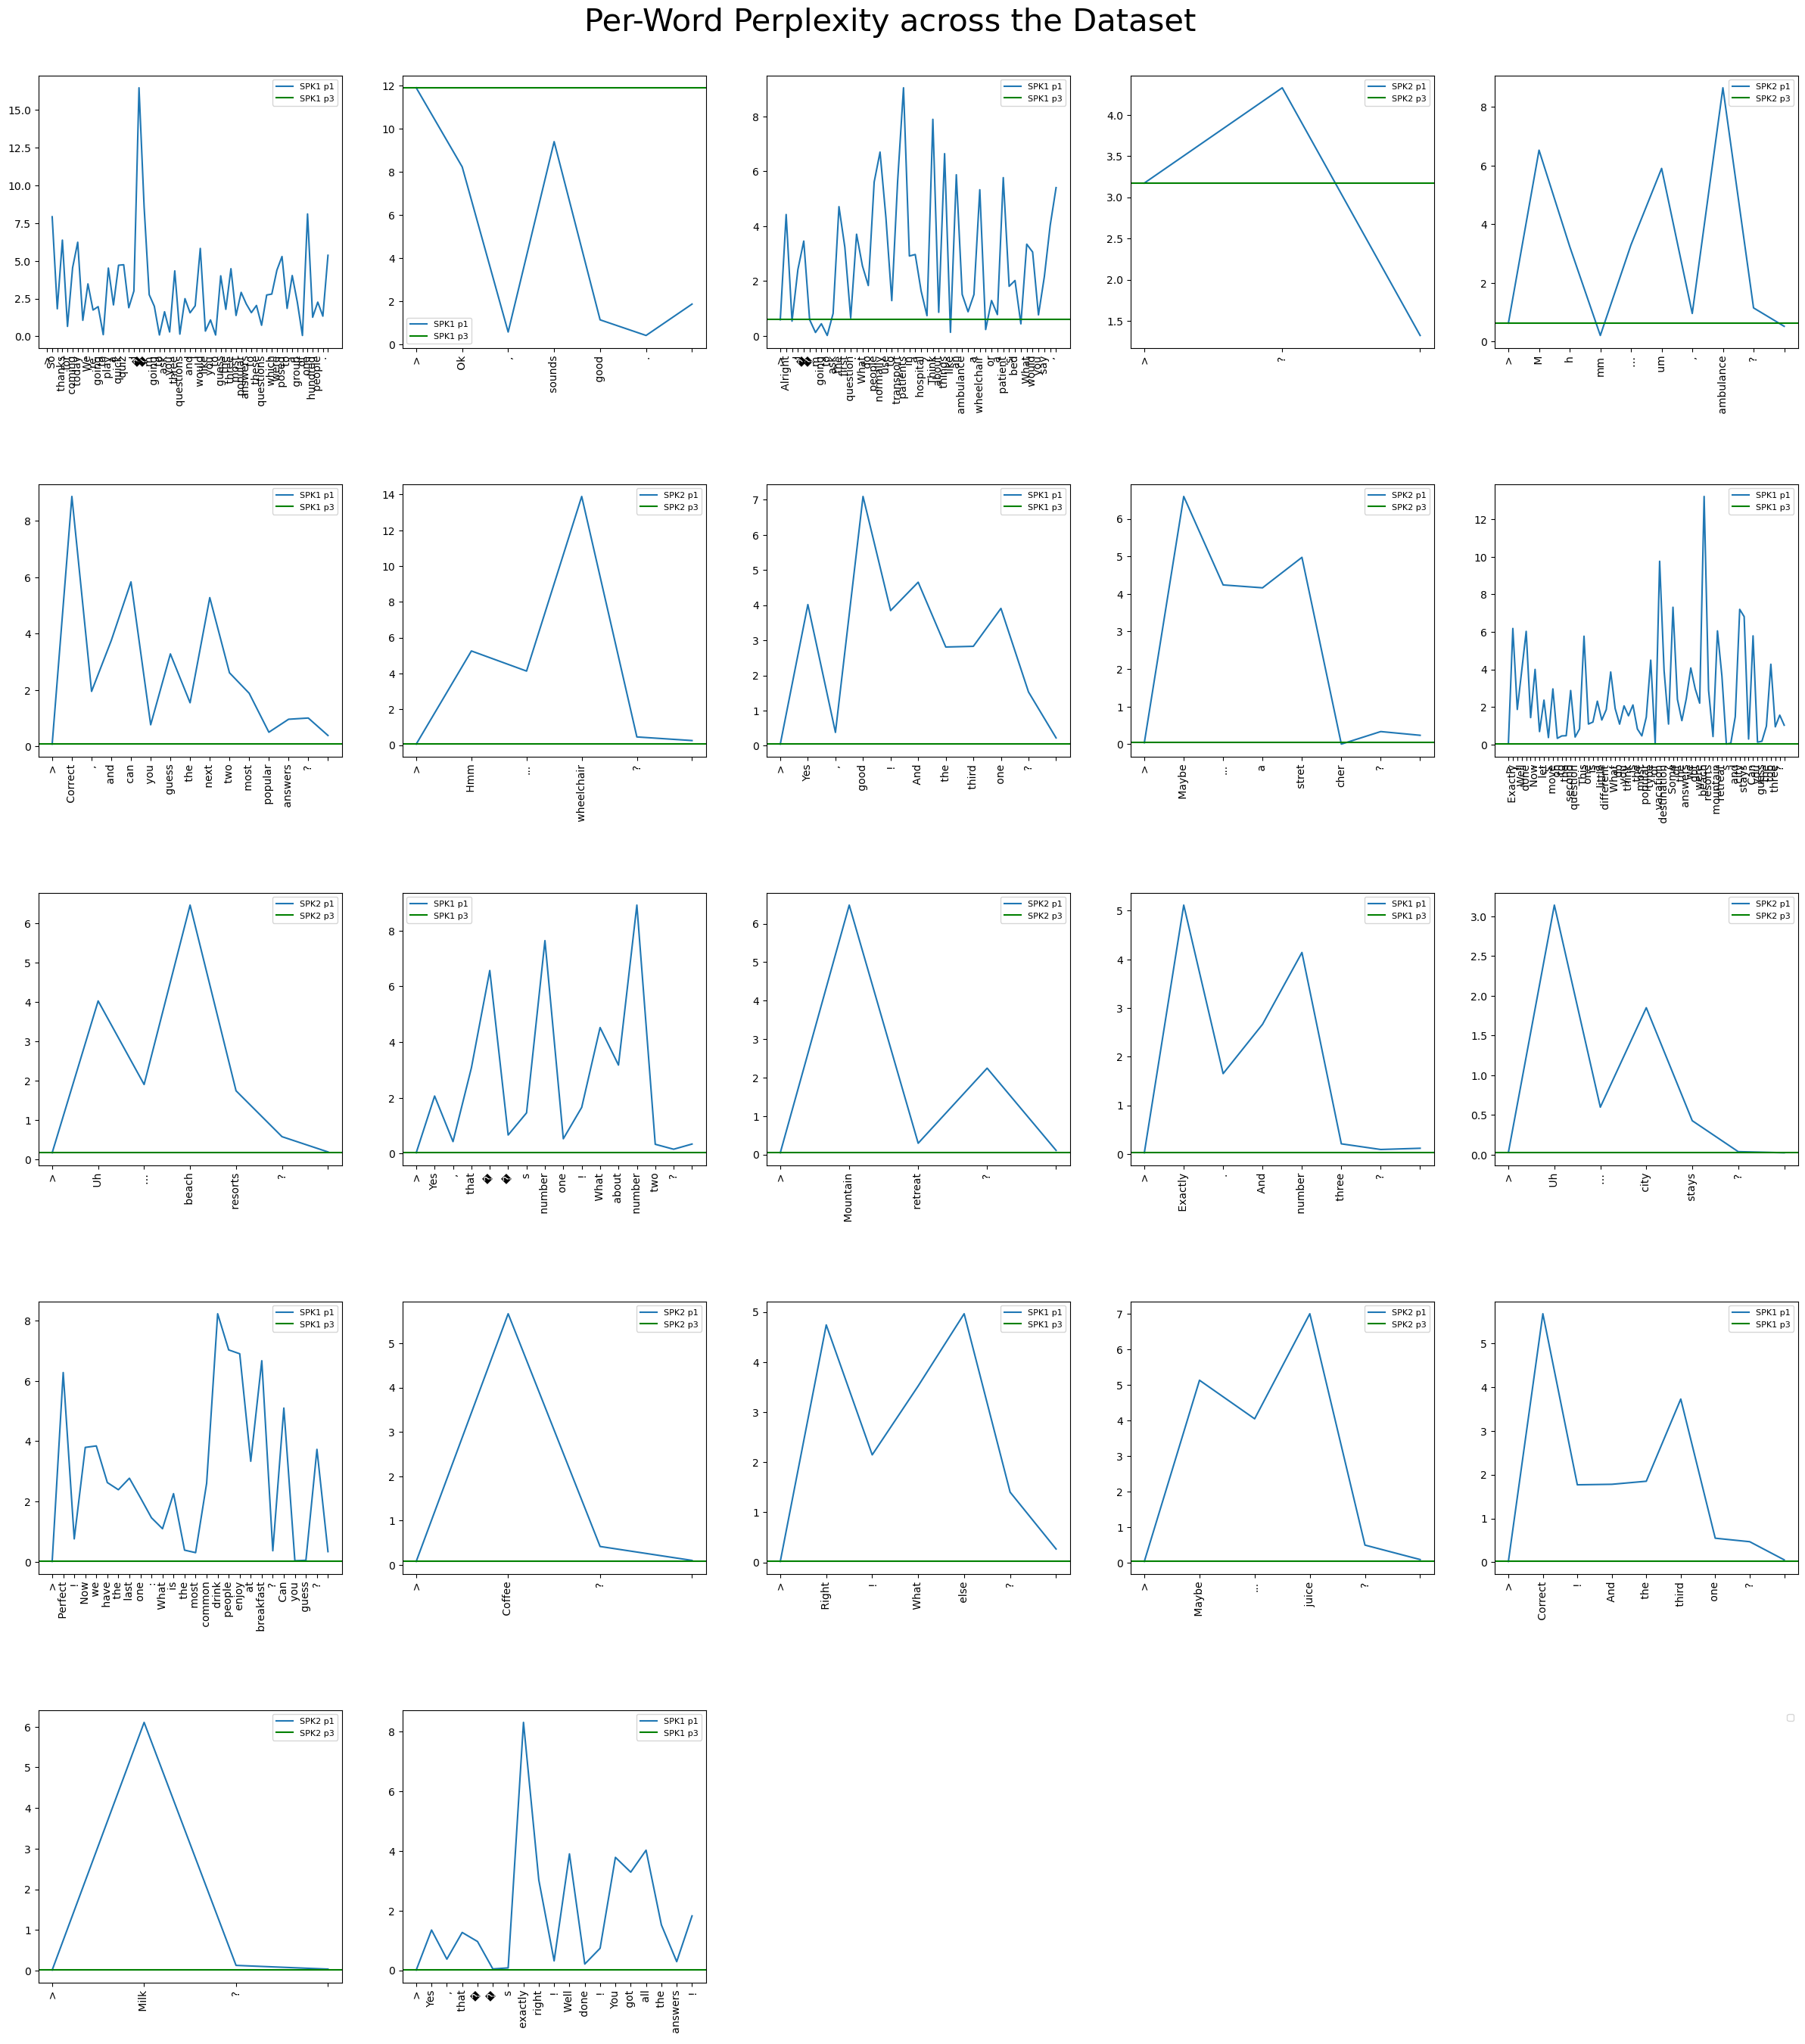

In [77]:
dominance = {}
for content, name in zip(proof_of_concept_df["file_content"], proof_of_concept_df["file_name"]):
    dominance[name] = {}
    pattern = '<(SPK[1-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
    compute_graph_perplexity(tokens,perplexity_scores_p1[name],perplexity_scores_p3[name],matches, pattern=pattern) 